# Data Analysis Workflow with Python

Author: Austin Pursley  
Date: 9/13/2022 

Here my goal is to document my current understanding of a data analysis workflow with Python. This demo will reflect a generic / made-up scenario, similar to device testing scenarios I'm familiar with. Nothing too substantive, just enough to illustrate how this goes. In this workflow, the data is given in the form of CSV files or similar, and will be collected, analyzed, and reported using pandas, matplotlib, Jinja, etc.

## Step 1: Collect Data
We want to first organize data as best as we can for analysis. This can be a challenge because 'raw' data can come from disparate sources. I set-up the dummy data to reflect this; in the made-up scenario, there are (1) three types of sensors, (2) each sensor has three units, (3) each unit has undergone three trials of data collection, and (4) each trial has three data points. Every sensor has created its own CSV file, so data from those files will have to be collected and formed into one whole.

### File list
The first step is to get a list of all of the data files. The CSV files are all in a "data" folder, and then themselves within their own sub folders. A recursive glob method can find all the CSV files within this folder hierarchy.

In [1]:
from pathlib import Path
data_dir = "data/"
csvs = list(Path(data_dir).rglob('*.csv'))
csvs_print = [str(f) for f in csvs]
csvs_print

['data/Sensor B/B-2.csv',
 'data/Sensor B/B-1.csv',
 'data/Sensor B/B-3.csv',
 'data/Sensor C/C-2.csv',
 'data/Sensor C/C-3.csv',
 'data/Sensor C/C-1.csv',
 'data/Sensor A/A-3.csv',
 'data/Sensor A/A-1.csv',
 'data/Sensor A/A-2.csv']

### Read Files
Then I can read the CSVs into pandas dataframes.

In [2]:
import pandas as pd

data_dict = {}
for f in csvs:
    data_dict[Path(f).stem] = pd.read_csv(f)

# As an example:
data_dict['A-1']

Sensor  Unit #  Trail                       Time  Value
0      A       1      1  2022-08-22T13:45:00-05:00     10
1      A       1      1  2022-08-22T13:46:00-05:00     15
2      A       1      1  2022-08-22T13:47:00-05:00     25
3      A       1      2  2022-08-22T13:55:00-05:00      9
4      A       1      2  2022-08-22T13:56:00-05:00     17
5      A       1      2  2022-08-22T13:57:00-05:00     27
6      A       1      3  2022-08-22T14:05:00-05:00      9
7      A       1      3  2022-08-22T14:06:00-05:00     17
8      A       1      3  2022-08-22T14:07:00-05:00     27

### Combine
Next I will combine the data into one dataframe (this could of been done in one step, but I like breaking it down like this.)

In [3]:
data_df = pd.concat(data_dict.values())

Let's examine the combined dataframe to make sure the data looks okay.

In [4]:
data_df

Sensor  Unit #  Trail                       Time  Value
0       B       2      1  2022-08-22T13:45:00-05:00     14
1       B       2      1  2022-08-22T13:46:00-05:00     20
2       B       2      1  2022-08-22T13:47:00-05:00     25
3       B       2      2  2022-08-22T13:55:00-05:00     10
4       B       2      2  2022-08-22T13:56:00-05:00     20
..    ...     ...    ...                        ...    ...
4       A       2      2  2022-08-22T13:56:00-05:00     19
5       A       2      2  2022-08-22T13:57:00-05:00     33
6       A       2      3  2022-08-22T14:05:00-05:00     11
7       A       2      3  2022-08-22T14:06:00-05:00     21
8       A       2      3  2022-08-22T14:07:00-05:00     30

[81 rows x 5 columns]

### Clean
Looks pretty good. One change that needs fixing is the index should be reset.

In [5]:
data_df.reset_index(inplace=True, drop=True)

There is also a typo, "Trail" should be "Trial" (whoops). Instead of editing the CSV files, I will just make the change here.

In [6]:
data_df.rename(columns={'Trail' : 'Trial'}, inplace=True)

Now let's look at the data types that was atomically determined when the CSV was read.

In [7]:
data_df.dtypes

Sensor    object
Unit #     int64
Trial      int64
Time      object
Value      int64
dtype: object

The 'Time' column does not have the correct type, it should be 'datetime'. It's not critical here but incorrect date/time data seems to be a common issue, so I'll make a point to correct it.

In [8]:
data_df['Time'] = pd.to_datetime(data_df['Time'])
display(data_df['Time'].dtypes)
# A quick check to make sure it's working
display(data_df['Time'][1] - data_df['Time'][0])

datetime64[ns, pytz.FixedOffset(-300)]

Timedelta('0 days 00:01:00')

There we go, we've got our data neatly collected in one place and cleaned up a bit.

This dummy data is uniform, so it's straightforward to combine them. But 'real' data can have more variation and quirks. Different Date-time formatting, CSVs with extra columns, data that needs many more corrections, etc. In all cases, care should taken to be sure the data is congruent and correct.

## Step 2: Analysis
This will be a fairly straightforward analysis of the collected data using Python's pandas library. I've tried to highlight some tricks / capabilities of pandas to demonstrate its power.

### Grouping
With pandas, it's easy to group data for analysis. As an example, let's look at descriptive statistics. As seen in the tables below, I can either get statistics for each individual sensor unit or for each sensor type.

In [9]:
descr_stats_by_unit = data_df.groupby(['Sensor','Unit #'])['Value'].agg(['min','max','mean'])
descr_stats_by_unit

min  max       mean
Sensor Unit #                     
A      1         9   27  17.333333
       2         5   33  19.000000
       3         5   35  19.888889
B      1        14   35  24.000000
       2        10   35  21.666667
       3         4   32  19.222222
C      1         8   14  10.444444
       2         9   21  15.000000
       3         1   20   9.222222

In [10]:
descr_stats_by_sensor = data_df.groupby(['Sensor'])['Value'].agg(['min','max','mean'])
descr_stats_by_sensor

min  max       mean
Sensor                     
A         5   35  18.740741
B         4   35  21.629630
C         1   21  11.555556

### Scoring
Assigning a pass/fail or similar scoring metric may be part of the analysis.

I've made up a scoring system for this scenario: 
- A Trial is a "Pass" if the sensor reached over 20 in a Trial.
- A unit is a "Pass" if all of its associated Trials are a "Pass".
- A sensor is a "Pass" if all of its associated Trials are a "Pass".

With the ability to group data, I can build out the scoring analysis throughout the different "levels" of data, starting with "by trail" and ending with "by sensor".

In [11]:
# By Trial
trial_score = data_df.groupby(['Sensor','Unit #', 'Trial'])['Value'].agg(['max'])
trial_score['Pass?'] = trial_score['max'].apply(lambda c: True if c >= 20 else False)
trial_score['Score'] = trial_score['Pass?'].map({True: 'Pass', False: 'Fail'})
trial_score_display = trial_score[['max','Score']]
trial_score

max  Pass? Score
Sensor Unit # Trial                  
A      1      1       25   True  Pass
              2       27   True  Pass
              3       27   True  Pass
       2      1       27   True  Pass
              2       33   True  Pass
              3       30   True  Pass
       3      1       35   True  Pass
              2       27   True  Pass
              3       29   True  Pass
B      1      1       33   True  Pass
              2       34   True  Pass
              3       35   True  Pass
       2      1       25   True  Pass
              2       30   True  Pass
              3       35   True  Pass
       3      1       32   True  Pass
              2       20   True  Pass
              3       23   True  Pass
C      1      1       14  False  Fail
              2       14  False  Fail
              3       11  False  Fail
       2      1       20   True  Pass
              2       21   True  Pass
              3       20   True  Pass
       3      1       14  False  Fail
              2       20   True  Pass
              3        5  False  Fail

In [12]:
# By unit
unit_score = trial_score.groupby(['Sensor', 'Unit #'])['Pass?'].agg(['sum'])
unit_score.rename(columns={'sum' : 'Trials Passed'}, inplace=True)
unit_score['Trials Total'] =  trial_score.groupby(['Sensor', 'Unit #'])['Pass?'].agg(['count'])
unit_score['Trials %'] = unit_score['Trials Passed'] / unit_score['Trials Total']
unit_score['Trials'] = unit_score['Trials Passed'].astype(str) + "/" + unit_score['Trials Total'].astype(str)
trial_score_cat = trial_score.astype("category")
unit_score['Pass?'] = trial_score_cat.groupby(['Sensor', 'Unit #'])['Pass?'].agg(['all'])
unit_score['Score'] = unit_score['Pass?'].map({True: 'Pass', False: 'Fail'})
unit_score_display = unit_score[['Trials', 'Score']]
unit_score

Trials Passed  Trials Total  Trials % Trials  Pass? Score
Sensor Unit #                                                           
A      1                   3             3  1.000000    3/3   True  Pass
       2                   3             3  1.000000    3/3   True  Pass
       3                   3             3  1.000000    3/3   True  Pass
B      1                   3             3  1.000000    3/3   True  Pass
       2                   3             3  1.000000    3/3   True  Pass
       3                   3             3  1.000000    3/3   True  Pass
C      1                   0             3  0.000000    0/3  False  Fail
       2                   3             3  1.000000    3/3   True  Pass
       3                   1             3  0.333333    1/3  False  Fail

In [13]:
# By Sensor
sensor_score = trial_score.groupby(['Sensor'])['Pass?'].agg(['sum'])
sensor_score.rename(columns={'sum' : 'Trials Passed'}, inplace=True)
sensor_score['Trials Total'] = trial_score.groupby(['Sensor'])['Pass?'].agg(['count'])
sensor_score['Trials %'] = sensor_score['Trials Passed'] / sensor_score['Trials Total']
sensor_score['Trials By Unit'] = unit_score.groupby(['Sensor'])['Trials'].apply(lambda x: '; '.join(x))
sensor_score['Trials Total'] = sensor_score['Trials Passed'].astype(str) + "/" + sensor_score['Trials Total'].astype(str)
sensor_score['Units Passed'] = unit_score.groupby(['Sensor'])['Pass?'].agg(['sum'])
sensor_score['Units Total'] = unit_score.groupby(['Sensor'])['Pass?'].agg(['count'])
sensor_score['Units %'] = sensor_score['Units Passed'] / sensor_score['Units Total']
sensor_score['Units'] = sensor_score['Units Passed'].astype(str) + "/" + sensor_score['Units Total'].astype(str)
sensor_score['Pass?']  = trial_score.groupby(['Sensor'])['Pass?'].agg(['all'])
sensor_score['Score'] = sensor_score['Pass?'].map({True: 'Pass', False: 'Fail'})
sensor_score_display = sensor_score[['Trials By Unit', 'Trials Total', 'Units', 'Score']]
sensor_score

Trials Passed Trials Total  Trials % Trials By Unit  Units Passed  \
Sensor                                                                      
A                   9          9/9  1.000000  3/3; 3/3; 3/3             3   
B                   9          9/9  1.000000  3/3; 3/3; 3/3             3   
C                   4          4/9  0.444444  0/3; 3/3; 1/3             1   

        Units Total   Units % Units  Pass? Score  
Sensor                                            
A                 3  1.000000   3/3   True  Pass  
B                 3  1.000000   3/3   True  Pass  
C                 3  0.333333   1/3  False  Fail

### Plots

Pandas has built in methods to plot data, which use the matplotlib library by default. However, these methods can be cumbersome. I almost always skip them and use matplotlib "as is".

Below I've made two plots to demo matplotlib. The first was a result of my intuition to first try plotting every trial. It's a good example of how to get pandas grouping and matplotlib plotting to work together. However, I realized it could be improved by plotting by sensor unit, which is seen in the second plot.

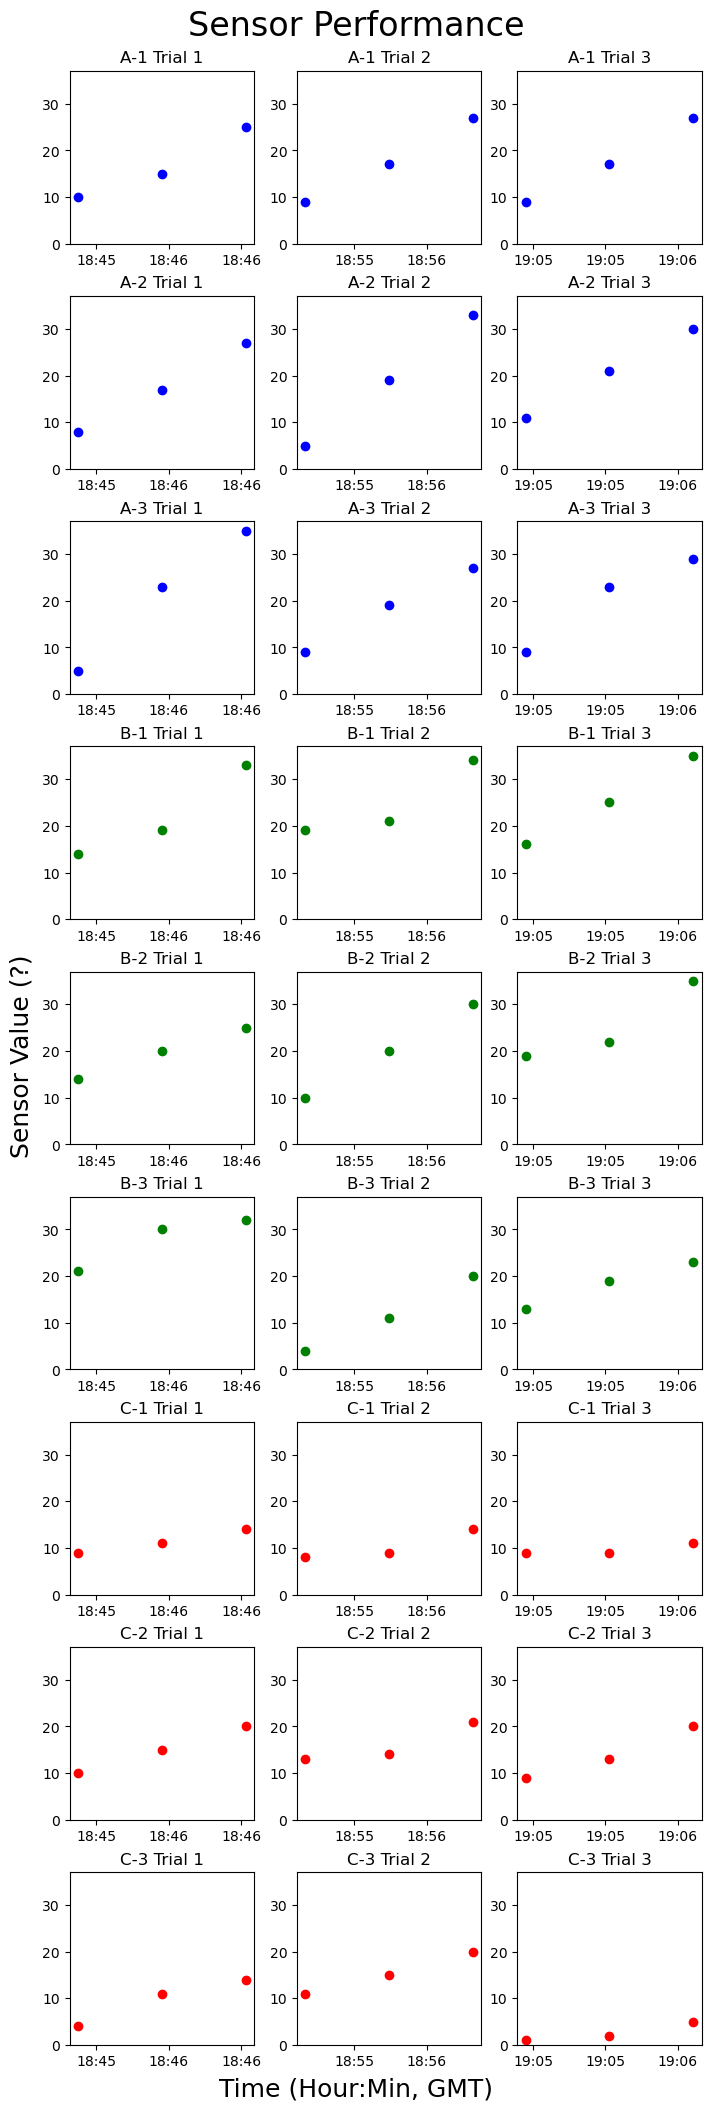

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
fig, axs = plt.subplots(9,3,figsize=(7,21),constrained_layout=True)
grouped = data_df.groupby(['Sensor','Unit #','Trial'])
targets = zip(grouped.groups.keys(), axs.flatten())
fig.suptitle('Sensor Performance', fontsize=24)
fig.supxlabel('Time (Hour:Min, GMT)', fontsize=18)
fig.supylabel('Sensor Value (?)', fontsize=18)
for i, (key, ax) in enumerate(targets):
    unit=key[0]
    unit_num=key[1]
    trial_num=key[2]
    ax.set_title(f"{unit}-{unit_num} Trial {trial_num}")
    if unit == 'A':
        color = 'blue'
    elif unit == 'B':
        color = 'green'
    else:
        color = 'red'
    dfg = grouped.get_group(key)
    ax.scatter(dfg['Time'],dfg['Value'],color=color)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_ylim([0,37])
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
#plt.savefig('plots/sensor_performance_by_trail.jpg')
plt.show()

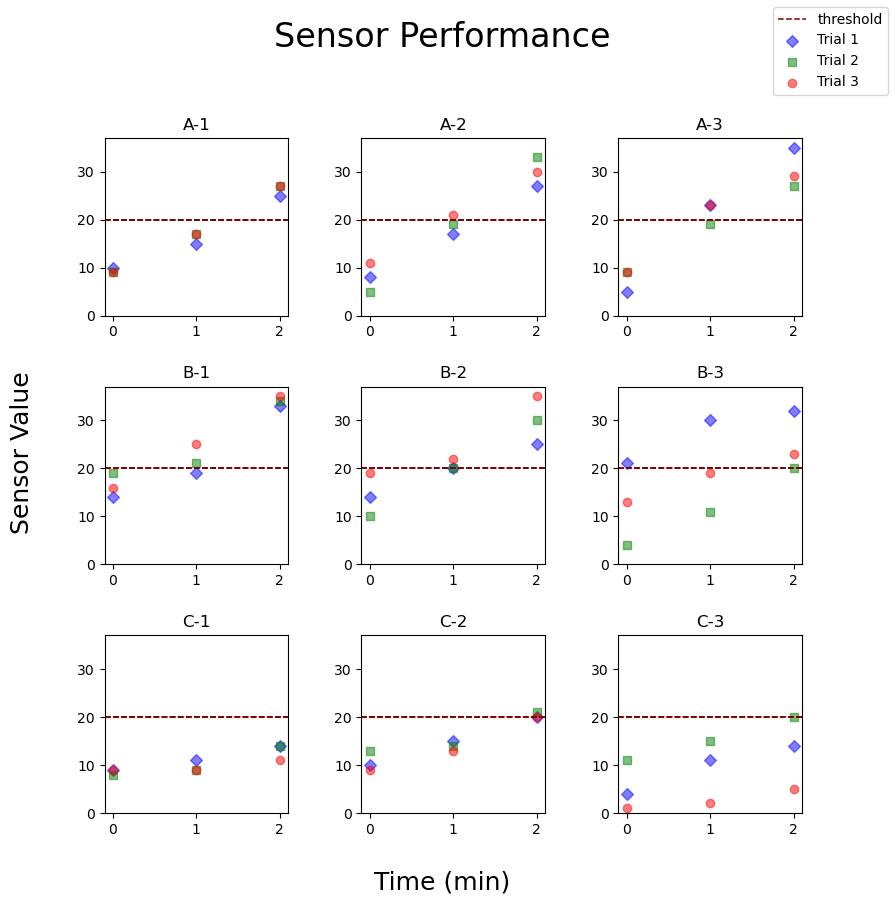

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
fig, axs = plt.subplots(3,3,figsize=(9,9))
grouped = data_df.groupby(['Sensor','Unit #'])
targets = zip(grouped.groups.keys(), axs.flatten())
fig.suptitle('Sensor Performance', fontsize=24)
fig.supxlabel('Time (min)', fontsize=18)
fig.supylabel('Sensor Value', fontsize=18)
for i, (key, ax) in enumerate(targets):
    unit=key[0]
    unit_num=key[1]
    ax.set_title(f"{unit}-{unit_num}")
    dfg = grouped.get_group(key)
    for i, (Trial,dfTrial) in enumerate(dfg.groupby(['Trial'])):
        dfTrial = dfTrial.reset_index(drop=True)
        dfTrial = dfTrial.reset_index()
        if Trial == 1:
            color = 'blue'
            marker = 'D'
        elif Trial == 2:
            color = 'green'
            marker = 's'
        else:
            color = 'red'
            marker = 'o'
        ax.axhline(y=20, color='maroon', linestyle='--', label="threshold",linewidth=1.1)
        ax.scatter(dfTrial['index'],dfTrial['Value'],color=color,label=f'Trial {Trial}', alpha=.5, marker=marker)
    ax.set_ylim([0,37])
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # removes duplicate legends
fig.subplots_adjust(top=0.85,bottom=0.1, hspace = 0.4, wspace = 0.4)
fig.legend(by_label.values(), by_label.keys(), loc='upper right')
plt.savefig('plots/sensor_performance_by_unit.jpg')
plt.show()

## Step 3: Report

Now that I've done the analysis with Python, I want to present those results in a LaTeX document. I just use LaTeX because I'm familiar with it through work. I think a Juypter notebook like this one would work just as well.

### Tables
Panda has a ['to_latex'](https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.to_latex.html) method for converting dataframes to LaTeX table code. It is decent, but not as good as its HTML/CSS counterpart due to lacking features and has a few bugs. I've managed to make it work through some workarounds. I've especially found it works out better to aim for a "half-way" solution that you can be tailored and polished later in the LaTeX editor (e.g. Overleaf).

I'm going to show how two different styles of LaTeX tables can be achieved. One is the booktabs style, which is used for a lot of scientific and technical publications. The other is what might be considered the default "lines" table.

#### Booktabs style
The code below is going to generate LaTeX table code for each set of data (i.e. dataframes) I've selected.

Here is screenshot of what one of these booktabs styled tables will look like after being compiled:

![Example of booktabs styled table](assets/analysis-workflow-tbl-booktabs-example.png)


In [16]:
import re

def text_to_latex(text):
    # lazy funciton to fix symbols for LaTeX
    if isinstance(text, str):
        if text == "nan":
            return ""
        else:
            if "%" in text:
                text = re.sub(r"%", r"\%", text)
            if "&" in text:
                text = re.sub("&", r"\&", text)
            if "μ" in text:
                text = text.replace("μ", r"$\mu$")
            if "" in text:
                text = text.replace("Δ", r"$\delta$")
            if "_" in text:
                text = text.replace("_", r"\_")
            if "#" in text:
                text = text.replace("#", r"\#")
            if "\n" in text:
               text = text.replace("\n", " \\newline ")
            # if "Unnamed" in text:
            #     text = " "
    return text

def fix_multi_row_for_longtable(latex):
    # see multirow package documentation for how this works
    lines = latex.split('\n')
    body_start = False
    last_starred = -1
    for i, l in enumerate(lines):
        if "endlastfoot" in l:
            body_start = True
            continue
        if body_start:
            if 'multirow' in l or 'end{longtable}' in l:
                if last_starred != -1:
                    lines[last_starred] = lines[last_starred].replace(r'\\*',r'\\')
            if r'\\' in l:
                lines[i] = lines[i].replace(r'\\',r'\\*')
                last_starred = i
    return '\n'.join(lines)

def passfail(c):
    # applies color to cells with "pass" or "fail" in them.
    if c.lower() == 'pass':
        color = "light-green"
    elif c.lower() == 'fail':
        color = 'light-red'
    else:
        return None
    return f"background-color:{color};"

def color_fract(c, denom):
    if isinstance(c, str):
        pattern_search = fr"([^{denom}]/{denom})"
        pattern_replace = r'\\textcolor{red}{\1}'
        sub = re.sub(pattern_search, pattern_replace, str(c))
    else:
        return c
    return sub
def bold(c):
    return f"textbf:--rwrap;"

# list of dataframes going to convert to LateX code
df_to_latex_tbl_list = [descr_stats_by_unit, descr_stats_by_sensor, trial_score_display, unit_score_display, sensor_score_display]
captions = ["Sensor performance descriptive statistics by unit.",
           "Sensor performance descriptive statistics by sensor.",
           "Sensor perforamnce scoring by trail.",
           "Sensor perforamnce scoring by unit.",
           "Sensor perforamnce scoring by trail."]
latex_tables = []
for df, caption in zip(df_to_latex_tbl_list, captions):
    tdf = df.copy()
    # apply replacements for certain symbols for LaTeX
    tdf = tdf.applymap(text_to_latex)
    tdf.columns = pd.Series(tdf.columns).apply(text_to_latex)
    tdf.index.names = pd.Series(tdf.index.names).apply(text_to_latex)
    # additional colors for scores (easier avoid styler for this)
    tdf = tdf.applymap(color_fract,denom=3)
    tdf = tdf.applymap(color_fract,denom=9)
    # styler
    styler = tdf.style
    styler.applymap_index(bold, axis="columns")
    styler.applymap_index(bold, axis="index")
    styler.format({'mean' : '{:.2f}', 'Trials \%' : '{:.2f}', 'Units \%' : '{:.2f}' })
    if "Score" in list(tdf.columns):
        styler.applymap(passfail, subset="Score")
    # I cannot figure out how to apply style to multi index names, so I am doing so "manually"
    tdf.index.names = pd.Series(tdf.index.names).apply(lambda v: rf'\textbf{{{v}}}')
    tbl = styler.to_latex(environment="longtable", position="H", caption=caption, hrules=True, convert_css=True)
    tbl = fix_multi_row_for_longtable(tbl)
    # apply some additional color
    latex_tables.append(tbl)
    

#### "Lines" Style

A screenshot of one of the "lines" styled tables:

![Example of 'lines' styled table](assets/analysis-workflow-tbl-lines-example.png)

In [17]:
import jinja2
def build_col_format(head, style_col_format, vline=True):
    # function to build column format string for LaTeX tables.
    # Especially needed for those that have vertical lines.
    # e.g. for a 3 column table: "|l|l|l|"
    #                in context: \begin{longtable}{|l|l|l|}{...}
    if "default" not in style_col_format:
        style_col_format["default"] = "l"
    col_format = ""
    for i, c in enumerate(head):
        if c in style_col_format:
            col_type = style_col_format[c]
        else:
            col_type = style_col_format["default"]
        if i == 0:
            if vline == True:
                col_type = "|" + col_type
        col_format += col_type
    if vline == True and col_format[-1] != "|":
        col_format += "|"
    return col_format

templates_dir = "templates/"
table_template_fn = "longtable_default_custom.tex"
# set-up Jinja template environment
templateLoader = jinja2.FileSystemLoader(searchpath=templates_dir)
templateEnv = jinja2.Environment(loader=templateLoader, trim_blocks=True)
table_template = templateEnv.get_template(table_template_fn)

for df, caption in zip(df_to_latex_tbl_list, captions):
    tdf = df.copy()
    head = list(tdf.index.names) + list(tdf.columns)
    style_col_format = {"default" : "c|"}
    column_format = build_col_format(head, style_col_format)
    ## apply replacements for certain symbols for LaTeX
    tdf = tdf.applymap(text_to_latex)
    tdf.columns = pd.Series(tdf.columns).apply(text_to_latex)
    tdf.index.names = pd.Series(tdf.index.names).apply(text_to_latex)
    # additional colors for scores (easier avoid styler for this)
    tdf = tdf.applymap(color_fract,denom=3)
    tdf = tdf.applymap(color_fract,denom=9)
    # styler
    styler = tdf.style
    styler.template_latex = table_template
    styler.applymap_index(bold, axis="columns")
    styler.applymap_index(bold, axis="index")
    styler.format({'mean' : '{:.2f}', 'Trials \%' : '{:.2f}', 'Units \%' : '{:.2f}' })
    if "Score" in list(tdf.columns):
        styler.applymap(passfail, subset="Score")
    # I cannot figure out how to apply style to multi index names, so I am doing so "manually"
    tdf.index.names = pd.Series(tdf.index.names).apply(lambda v: rf'\textbf{{{v}}}')
    # add other data for custom template, to fix/adjust a few things
    templateEnv.globals.update(hlines=False, hlines_head=True, colnum=len(head),head_color='light-gray')
    tbl = styler.to_latex(environment="longtable",position="H", caption=caption+" (lines style)",
                          column_format=column_format,convert_css=True, clines="all;index")
    tbl = fix_multi_row_for_longtable(tbl)
    latex_tables.append(tbl)

### Figures
The plots can be added through figures within LaTeX. Even though the code is simple, I've went ahead and created a separate template for them.

In [18]:
fig_template_fn = "figure_template.tex"
# set-up Jinja template environment
templateLoader = jinja2.FileSystemLoader(searchpath=templates_dir)
templateEnv = jinja2.Environment(loader=templateLoader, trim_blocks=True)
table_template = templateEnv.get_template(fig_template_fn)

plots = [str(f.name) for f in list(Path('plots/').glob('*.jpg'))]
captions = ["Sensor Performance scatter plot all trails", "Sensor perforamance scatter plot by unit."]
latex_plots = []
for p, caption in zip(plots,captions):
    latex_plots.append(table_template.render(position="H",caption=caption, img_name=p))

### Report Template
I've used Jinja templates to create LaTeX tables and figures, and now I'm going to use another template to generate a full LaTeX document with those tables and figures. The resulting document will be very basic, good for testing elements will compile correctly, but it could be a nearly formed report. Generating the report with a template is especially useful for when there are a high number of tables and/or plots, although of course that's not the case here. For actual documents that are simple, it may be make more sense to skip this report template.

The generated report is printed below and the resulting PDF (compiled in Overleaf) can be seen [here](assets/analysis_pipeline_latex_report.pdf). Looking at the report, some tables are not set exactly how I'd want them. But, again, the goal was not to generate perfect table and plots, it was just to get them mostly complete and ready for refinement.

In [19]:
templates_dir = "templates/"
report_template_fn = "analysis_report.tex"
# set-up Jinja template environment
templateLoader = jinja2.FileSystemLoader(searchpath=templates_dir)
templateEnv = jinja2.Environment(loader=templateLoader, trim_blocks=True)
report_template = templateEnv.get_template(report_template_fn)
latex_plots = [latex_plots[1]] # only taking second plot
print(report_template.render(plots = latex_plots, tables = latex_tables))


\documentclass{article}
\usepackage[utf8]{inputenc}
\RequirePackage{longtable}
\RequirePackage[table]{xcolor}
\RequirePackage{color, colortbl}
\RequirePackage{graphicx}
\RequirePackage{booktabs}
\RequirePackage[longtable]{multirow}
\RequirePackage{float}

\title{Demo for Analysis Pipeline}
\author{Austin Pursley }
\date{September 2022}

\definecolor{light-green}{RGB}{179, 255, 179}
\definecolor{light-red}{RGB}{255, 102, 102}
\definecolor{light-gray}{gray}{0.85}

\setlength{\arrayrulewidth}{1.0pt} 
\renewcommand{\arraystretch}{1.3}

\graphicspath{ {plots/} }

\begin{document}

\maketitle

\section{Analysis Results}

\begin{figure}[H]
\caption{Sensor perforamance scatter plot by unit.}\centering
\includegraphics[width=0.9\textwidth]{sensor_performance_by_unit.jpg}\end{figure}


\begin{longtable}[H]{llrrr}
\caption{Sensor performance descriptive statistics by unit.} \\
\toprule
 &  & \textbf{min} & \textbf{max} & \textbf{mean} \\
\textbf{Sensor} & \textbf{Unit \#} &  &  &  \\
\midrule
\en